In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import argparse
import pickle

plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['text.usetex'] = True

def get_test_mrr(file_path):
    try:
        with open(file_path, 'r') as f:
            mrr = None
            for lines in f:
                if lines.startswith('\ttest AP'):
                    mrr = float(lines.strip('\n').split(':')[-1])
                    return mrr
    except FileNotFoundError:
        import pdb; pdb.set_trace()
        pass

def get_best_epoch(file_path):
    try:
        with open(file_path, 'r') as f:
            epoch = None
            for lines in f:
                if lines.startswith('Loading'):
                    epoch = int(lines.split(' ')[4])
                    return epoch
    except FileNotFoundError:
        import pdb; pdb.set_trace()
        pass

In [35]:
parser = argparse.ArgumentParser()
parser.add_argument('--trial', type=str, help='trial name')
parser.add_argument('--log_dir', type=str, default='log', help='log file directory')
parser.add_argument('--pkl_path', type=str, default='')
parser.add_argument('--target', type=str, default='mrr', choices=['mrr', 'epoch'])
parser.add_argument('--num_scope', type=int, default=25, help='trial name')
parser.add_argument('--num_neighbor', type=int, default=10, help='trial name')
parser.add_argument('--runs', type=int, default=5, help='trial name')
parser.add_argument('--layers', type=int, default=1, help='layer number')
parser.add_argument('--fontsize', type=int, default=32, help='font size')
parser.add_argument('--no_title', action='store_true')
parser.add_argument('--save_legends', action='store_true')

args = parser.parse_args(['--pkl_path', '../all_mrrs_0318.pkl', '--no_title', '--save_legend', '--fontsize', '40'])
log_dir = args.log_dir
config_dir = 'config' + '/{}'.format(args.trial)
# Optionally, you can set the font size as well
plt.rcParams['font.size'] = args.fontsize
if args.layers == 1:
    # scans = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '20', '50', '100']
    scans = ['1', '2', '5', '10', '20', '50', '100']
    intscans = [int(k) for k in scans]
else:
    scans = ['5x5', '5x10', '10x5', '10x10']
datasets = ['WIKI', 'uci', 'Flights', 'LASTFM', 'mooc']
show_datasets = {
    'WIKI': 'Wikipedia',
    'REDDIT': 'REDDIT',
    'Flights': 'Flights',
    'LASTFM': 'LASTFM',
    'mooc': 'MOOC',
    'uci': 'UCI',
    'CollegeMsg': 'CollegeMsg'
}
aggrs = ['TGAT', 'GraphMixer']
show_aggrs = {
    'TGAT': 'Attention',
    'GraphMixer': 'MLP-Mixer'
}
samplings = ['re', 'uni',]
memorys = ['gru', 'embed', '']
show_memorys = {
    'gru': 'RNN',
    'embed': 'Embedding',
    '': 'None'
}

# colors = [
# '#ff8a65',
# '#ffd54f',
# '#aed581',
# '#4db6ac',
# '#4fc3f7',
# '#7986cb'
# ]

colors = [
    '#e74c3c',
    # '#e67e22',
    '#f1c40f',
    # '#2ecc71',
    # '#3498db',
    '#008080',
    '#34495e',
    # '#000080'
]

In [36]:
all_data = {}

# load data
if os.path.exists(args.pkl_path):
    with open(args.pkl_path, 'rb') as f:
        all_data = pickle.load(f)
else:
    raise NotImplementedError


In [37]:
with open('../test_time_0319.pkl', 'rb') as f:
    test_time = pickle.load(f)

In [38]:
settings = {
    'uci':['TGAT', 'gru', 're'],
    'WIKI': ['TGAT', 'gru', 're'],
    'LASTFM': ['TGAT', 'embed', 're'],
    'Flights' : ['TGAT', 'embed', 're'],
}

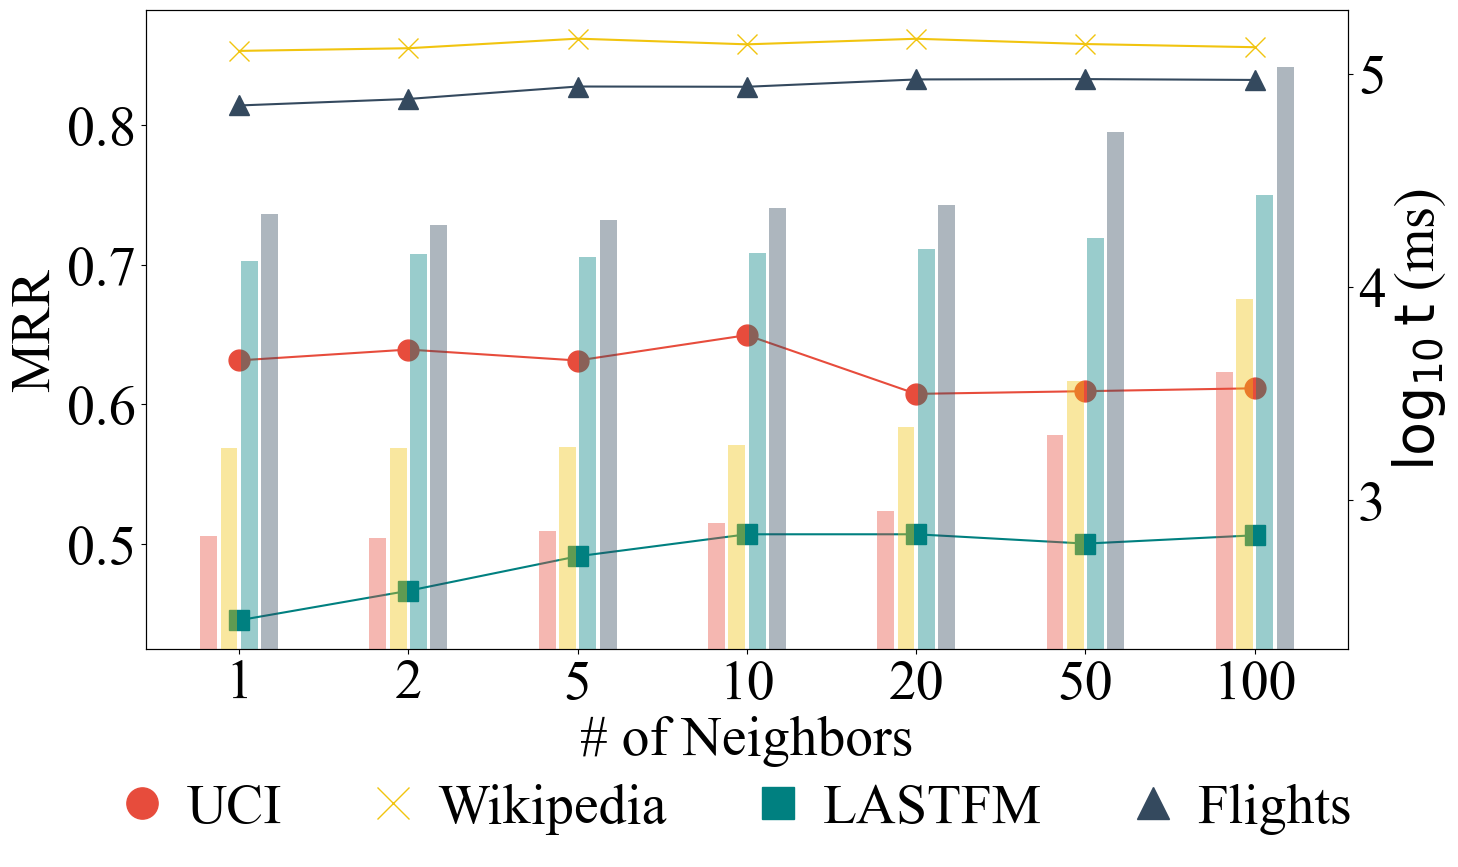

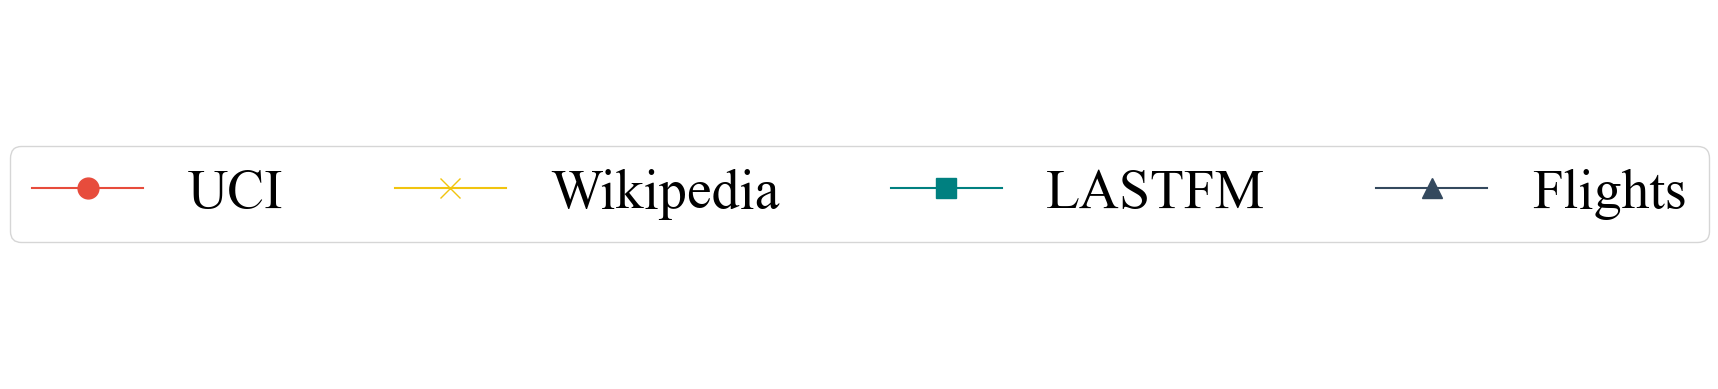

In [48]:

fig=  plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
fmts = ['-o', '-x', '-s', '-^']
handles = []
for i, dataset in enumerate(settings.keys()):
    df_mean = pd.DataFrame()
    df_std = pd.DataFrame()
    df_all = pd.DataFrame()
    aggr, memory, spl = settings[dataset]
    means = []
    stds = []
    times= []
    for ii, scan in enumerate(scans):
        results = np.array(all_data[dataset][scan][aggr][spl][memory])
        times.append(test_time[dataset][scan])
        if len(results) == args.runs:
            means.append(np.mean(results))
            stds.append(np.std(results))
        else:
            print(dataset, scan, aggr, memory)
    if len(means) != len(scans):
        print(dataset, all_data[dataset][scan][aggr][spl][memory])
    else:
        times = np.log10(np.array(times)*1000)
        # handles.append(plt.errorbar(x=intscans, y=means, yerr=stds, fmt=fmts[i], capsize=5, label=show_datasets[dataset], color=colors[i]))
        ax2.bar(np.array(range(len(scans)))+0.12*i-0.18, width=0.1, height=times, capsize=5, color=colors[i], alpha=0.4)
        handles.append(ax.errorbar(x=range(len(scans)), y=means, yerr=None, fmt=fmts[i], markersize=15, capsize=5, label=show_datasets[dataset], color=colors[i], alpha=1.))

title_str = ""
if not args.no_title:
    plt.title(title_str, x=0.5, y=1.05)
# x_labels = ['1']
# x_labels += ['' for _ in range(8)]
# x_labels += ['10', '20', '50', '100']
x_labels = scans
# plt.xticks(ticks=intscans, labels=x_labels)
ax.set_xticks(ticks=range(len(scans)),labels=x_labels)
# ax.set_ylim(0.4, 1)
ax2.set_ylim(2.3, 5.3)
ax.set_xlabel(f'# of Neighbors')
ax.set_ylabel(f'MRR')
ax2.set_ylabel(r'$\log_{10}\mathrm{t}$' + ' (ms)')

# plt.legend(loc='best', n)
# ax.legend(frameon=False, bbox_to_anchor=(1.15, 0.5), loc='center left', borderaxespad=0, handlelength=0.,markerscale=2)
ax.legend(frameon=False, bbox_to_anchor=(0.5, -0.25), loc='center', borderaxespad=0, handlelength=0.,markerscale=1.5, ncol=4)
# ax2.legend(frameon=False, bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0, handlelength=0., fontsize='small')
plt.tight_layout()

plt.savefig(f'../figures/mem_saturate.pdf',bbox_inches='tight')

if args.save_legends:
    fig, ax = plt.subplots()

    legend = ax.legend(handles=handles, loc='center', ncol=len(handles))

    ax.axis('off')

    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('../figures/legend_3.pdf', bbox_inches=bbox)